# Activity: Build an XGBoost model

## Introduction

In this activity, you’ll build on the skills and techniques you learned in the decision tree and random forest lessons to construct your own XGBoost classification model. The XGBoost model is a very powerful extension of decision trees, so having a strong working familiarity with this process will strengthen your skills and resume as a data professional.

This activity is a continuation of the airlines project in which you built decision tree and random forest models. You will use the same data, but this time you will train, tune, and evaluate an XGBoost model. You’ll then compare the performance of all three models and decide which model is best. Finally, you’ll explore the feature importances of your model and identify the features that most contribute to customer satisfaction.


## Step 1: Imports

### Import packages

Begin with your import statements. First, import `pandas`, `numpy`, and `matplotlib` for data preparation. Next, import scikit-learn (`sklearn`) for model preparation and evaluation. Then, import `xgboost`, which provides the classification algorithm you'll implement to formulate your predictive model.

In [1]:
# Import relevant libraries and modules.

### YOUR CODE HERE ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

### Load the dataset

To formulate your model, `pandas` is used to import a csv of airline passenger satisfaction data called `Invistico_Airline.csv`. This DataFrame is called `airline_data`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# RUN THIS CELL TO IMPORT YOUR DATA. 

### YOUR CODE HERE ###

airline_data = pd.read_csv('Invistico_Airline.csv', error_bad_lines=False)

### Display the data

Examine the first 10 rows of data to familiarize yourself with the dataset.

In [3]:
# Display the first ten rows of data.

### YOUR CODE HERE ###
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,2,0,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,2,5,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,2,0,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,5,3,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,2,0,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

Next, observe the types of data present within this dataset.

In [4]:
# Display the data type for each column in your DataFrame.

### YOUR CODE HERE ###
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall the methods for exploring DataFrames.
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Recall a property of a `pandas` DataFrame that allows you to view the data type for each column.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `.dtypes` on your DataFrame `airline_data` to view the data type of each column.</details>

**Question:** Identify the target (or predicted) variable for passenger satisfaction. What is your initial hypothesis about which variables will be valuable in predicting satisfaction?

* satisfaction represents the classification variable to be predicted.
* Many of these variables seem like meaningful predictors of satisfaction. In particular, delays (either departure or arrival) may be negatively correlated with satisfaction.

## Step 2: Model preparation

Before you proceed with modeling, consider which metrics you will ultimately want to leverage to evaluate your model.

**Question:** Which metrics are most suited to evaluating this type of model?

* As this is a binary classfication problem, it will be important to evaluate not just accuracy, but the balance of false positives and false negatives that the model's predictions provide. Therefore, precision, recall, and ultimately the F1 score will be excellent metrics to use.
* The ROC AUC (Area Under the Receiver Operating Characteristic) score is also suited to this type of modeling.

### Prepare your data for predictions

You may have noticed when previewing your data that there are several non-numerical variables (`object` data types) within the dataset.

To prepare this DataFrame for modeling, first convert these variables into a numerical format.

In [8]:
# Convert the object predictor variables to numerical dummies.

### YOUR CODE HERE ###
airline_data_dummies = pd.get_dummies(airline_data,columns=['satisfaction','Customer Type','Type of Travel','Class'])
airline_data_dummies.columns

Index(['Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction_dissatisfied', 'satisfaction_satisfied',
       'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'Class_Business', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about feature engineering](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/5mEqu/introduction-to-feature-engineering).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the `pandas` function for transforming categorical data into "dummy" variables.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use the `get_dummies()` function on your DataFrame `airline_data` to create dummies for the categorical variables in your dataset. Note that your target variable will also need this treatment.</details>

### Isolate your target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [7]:
# Define the y (target) variable.

### YOUR CODE HERE ###
y = airline_data_dummies['satisfaction_satisfied']
# Define the X (predictor) variables.
X=airline_data_dummies.drop(['satisfaction_satisfied','satisfaction_dissatisfied'], axis = 1)
### YOUR CODE HERE ###

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about splitting your data into x and y](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/ozK9K/build-a-decision-tree-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

In `pandas`, use square brackets `[]` to subset your DataFrame by specifying which column(s) to select. Also, quickly subset a DataFrame to exclude a particular column by using the `drop()` function and specifying the column to drop.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

In this case, your target variable was split into two columns from the dummy split. Be sure to include only the column which assigns a positive (i.e., "satisfied") outcome as 1.
</details>

### Divide your data 

Divide your data into a training set (75% of the data) and test set (25% of the data). This is an important step in the process, as it allows you to reserve a part of the data that the model has not used to test how well the model generalizes (or performs) on new data.

In [9]:
# Perform the split operation on your data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.

### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about splitting your data between a training and test set](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/ozK9K/build-a-decision-tree-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

To perform the splitting, call the function in the `model_selection` module of `sklearn` on the features and target variable.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call the `train_test_split()` function, passing in both `features` and `target`, while configuring the appropriate `test_size`. Assign the output of this split as `X_train`, `X_test`, `y_train`, `y_test`.
</details>

## Step 3: Model building

### "Instantiate" your XGBClassifer

Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [10]:
# Define xgb to be your XGBClassifier.

### YOUR CODE HERE ###
xgb = XGBClassifier(objective='binary:logistic',random_state=0)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about constructing a classifier model from `xgboost`](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Note that the target variable in this case is a binary variable. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use the `XGBClassifier()` from `xgboost`. Set the objective as `binary:logistic`.
</details>

### Define the parameters for hyperparameter tuning

To identify suitable parameters for your `xgboost` model, first define the parameters for hyperparameter tuning. Specifically, define a range of values for `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`.

Consider a more limited range for each parameter to allow for timely iteration and model training.

In [11]:
# Define parameters for tuning as `cv_params`.

### YOUR CODE HERE ###
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about hyperparameter tuning using GridSearch cross-validation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/afopk/tune-a-decision-tree).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Consider a range of values for each parameter, similar to what you observed in the lesson. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Define these parameters using a Python dictionary in the following format: `{'parameter1': [range,of,values]}`</details>

**Question:** What is the likely effect of adding more estimators to your GridSearch?

* More estimators will initially improve the model's performance. However, increasing the number of estimators will also considerably increase the time spent during the GridSearch process, and there will be diminishing returns as the number of estimators continues to increase.

### Define how the models will be evaluated

Define how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [12]:
# Define your criteria as `scoring`.

### YOUR CODE HERE ###
scoring = {'accuracy', 'precision', 'recall', 'f1'}

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about [using metric evaluation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/afopk/tune-a-decision-tree) to determine the metrics you include.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Consider what you've learned about the limitations of only including a single metric, such as `accuracy`. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Define metrics which balance the false positives and false negatives in binary classification problems.

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [13]:
# Construct your GridSearch.

### YOUR CODE HERE ###
xgb_cv = GridSearchCV(xgb, cv_params,scoring=scoring,cv=5,refit='f1')

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about constructing a GridSearch for [cross-validation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/W4vAW/verify-performance-using-validation).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Balance the time spent on validation with the number of folds you choose. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Choose the refit method which simultaneously balances false positives and false negatives.

### Fit the GridSearch model to your training data

If your GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

**Note:** The following cell might take several minutes to run.

In [14]:
%%time
# fit the GridSearch model to training data

### YOUR CODE HERE ###
xgb_cv = xgb_cv.fit(X_train,y_train)
xgb_cv

CPU times: user 3min 18s, sys: 3.96 s, total: 3min 22s
Wall time: 1min 46s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     predictor=None, random_state=0,
                                     reg_alpha=None, ...),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 

**Question:** Which optimal set of parameters did the GridSearch yield?

Through accessing the best_params_ attribute of the fitted GridSearch model, the optimal set of hyperparameters was: {'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about the result of the GridSearch.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Once you've fitted the GridSearch model to your training data, there will be an attribute to access which yields to the optimal parameter set.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Access the `best_params_` attribute from your fitted model. </details>

### Save your model for reference using `pickle`

Use the `pickle` library you've already imported to save the output of this model.

In [15]:
# Use `pickle` to save the trained model.

### YOUR CODE HERE ###
pickle.dump(xgb_cv,open('xgb_cv.sav','wb'))

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about "pickling" prior models](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/FSnam/build-and-validate-a-random-forest-model-using-a-validation-data-set).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

The model to be pickled is the fitted GridSearch model from above. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `pickle.dump()`, reference the fitted GridSearch model, and provide a name for the pickle file.

### Use your fitted model to create predictions for your test set

First, define `nb` to be the relevant algorithm from `sklearn`.`naive_bayes`. Then, fit your model to your training data. You will use this fitted model to create predictions for your test data.

## Step 4: Results and evaluation

### Formulate predictions on your test set

To evaluate the predictions yielded from your model, leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.

First, use your trained model to formulate predictions on your test set.

In [16]:
# Apply your model to predict on your test data. Call this output "y_pred".

### YOUR CODE HERE ###
y_pred = xgb_cv.predict(X_test)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about creating predictions from trained models.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the fitted GridSearch model from your training set and predict the predictor variables you reserved in the train-test split.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `predict()` on your fitted model and reference `X_test` to create these predictions.
</details>

### Leverage metrics to evaluate your model's performance

Apply a series of metrics from scikit-learn to assess your model. Specifically, print the accuracy score, precision score, recall score, and f1 score associated with your test data and predicted values.

In [17]:
# 1. Print your accuracy score.

### YOUR CODE HERE ###
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.

### YOUR CODE HERE ###
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.

### YOUR CODE HERE ###
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.

### YOUR CODE HERE ###
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9340314136125655
precision score: 0.9465036952814099
recall score: 0.9327170868347339
f1 score: 0.9395598194130925


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about model evaluation for detail on these metrics](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the function in the `metrics` module in `sklearn` to compute each of these metrics.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `accuracy_score()`, `precision_score()`, `recall_score()`, and `f1_score()`, passing `y_test` and `y_pred` into each.
</details>

**Question:** How should you interpret your accuracy score?

* The accuracy score for this model is 0.934, or 93.4% accurate.

**Question:** Is your accuracy score alone sufficient to evaluate your model?

* In classification problems, accuracy is useful to know but may not be the best metric to evaluate this model.

**Question:** When observing the precision and recall scores of your model, how do you interpret these values, and is one more accurate than the other?

* Precision and recall scores are both useful to evaluate the correct predictive capability of the model because they balance the false positives and false negatives inherent in prediction. The model shows a precision score of 0.948, suggesting the model is very good at predicting true positives. This means the model correctly predicts whether the airline passenger will be satisfied. The recall score of 0.940 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset. These two metrics combined give a better assessment of model performance than the accuracy metric does alone.

**Question:** What does your model's F1 score tell you, beyond what the other metrics provide?*

* The F1 score balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. In this case, the F1 score is 0.944, which suggests very strong predictive power in this model.

### Gain clarity with the confusion matrix

Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.

Create a confusion matrix based on your predicted values for the test set.

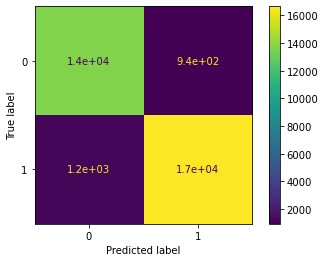

In [18]:
# Construct and display your confusion matrix.

# Construct the confusion matrix for your predicted and test values.

### YOUR CODE HERE ###

cm = metrics.confusion_matrix(y_test, y_pred)

# Create the display for your confusion matrix.

### YOUR CODE HERE ###

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot the visual in-line.

### YOUR CODE HERE ###

disp.plot()

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about model evaluation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the functions in the `metrics` module to create a confusion matrix.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `confusion_matrix`, passing in `y_test` and `y_pred`. Next, utilize `ConfusionMatrixDisplay()` to display your confusion matrix.
</details>

**Question:** When observing your confusion matrix, what do you notice? Does this correlate to any of your other calculations?

The top left to bottom right diagonal in the confusion matrix represents the correct predictions, and the ratio of these squares showcases the accuracy.

Additionally, the concentration of true positives and true negatives stands out relative to false positives and false negatives, respectively. This ratio is why the precision score is so high (0.944).

### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. Output and examine the feature importance of your model.

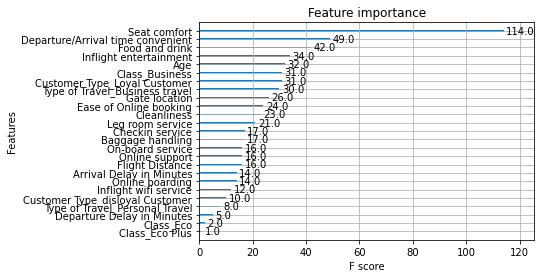

In [19]:
# Plot the relative feature importance of the predictor variables in your model.

### YOUR CODE HERE ###
plot_importance(xgb_cv.best_estimator_)


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall the attributes that are provided once the model is fitted to training data.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Examine the `best_estimator_` attribute of your fitted model.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

To easily visualize feature importance, call the built-in `plot_importance` function `xgboost` offers on the `best_estimator_`.</details>

**Question:** Examine the feature importances outputted above. What is your assessment of the result? Did anything surprise you?

1. By a wide margin, "seat comfort" rated as most important in the model.The type of seating is very different between first class and coach seating. However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature's importance.
2. Surprisingly, delays (both arrival and departure) did not score as highly important.

### Compare models

Create a table of results to compare model performance.

In [20]:
# Create a table of results to compare model performance.

### YOUR CODE HERE ###
table = pd.DataFrame()
table = table.append({'Model': "Tuned Decision Tree",
                        'F1':  0.945422,
                        'Recall': 0.935863,
                        'Precision': 0.955197,
                        'Accuracy': 0.940864
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "Tuned Random Forest",
                        'F1':  0.947306,
                        'Recall': 0.944501,
                        'Precision': 0.950128,
                        'Accuracy': 0.942450
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "Tuned XGBoost",
                        'F1':  f1_score,
                        'Recall': rc_score,
                        'Precision': pc_score,
                        'Accuracy': ac_score
                      },
                        ignore_index=True
                    )

table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.945422,0.935863,0.955197,0.940864
1,Tuned Random Forest,0.947306,0.944501,0.950128,0.942450
2,Tuned XGBoost,0.939560,0.932717,0.946504,0.934031


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Create a DataFrame and use the `append()` function to add the results of each model as a new row.

</details>

**Question:** How does this model compare to the decision tree and random forest models you built in previous labs? 

Based on the results shown in the table above, the F1, precision, recall, and accuracy scores of the XGBoost model are similar to the corresponding scores of the decision tree and random forest models. The random forest model seemed to outperform the decision tree model as well as the XGBoost model.

## Considerations

**What are some key takeaways you learned from this lab?**

1. The evaluation of the model is important to inform if the model has delivered accurate predictions.
2. Splitting the data is important for ensuring that there is new data for the model to test its predictive performance.
3. Each metric provides an evaluation from a different standpoint, and accuracy alone is not a strong way to evaluate a model.
4. Effective assessments balance the true/false positives versus true/false negatives through the confusion matrix and F1 score.

**How would you share your findings with your team?**

1. Showcase the data used to create the prediction and the performance of the model overall.
2. Review the sample output of the features and the confusion matrix to reference the model's performance.
3. Highlight the metric values, emphasizing the F1 score.
4. Visualize the feature importance to showcase what drove the model's predictions.

**What would you share with and recommend to stakeholders?**

1. The model created is highly effective at predicting passenger satisfaction.
2. The feature importance of seat comfort warrants additional investigation. It will be important to ask domain experts why they believe this feature scores so highly in this model.


**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged